In [1]:
from pathlib import Path
from typing import List, Tuple, Dict

# Wav Features and Visualization
import librosa
import IPython.display as ipd
# Basics
import numpy as np
import pandas as pd
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# Machine Learning
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# View Data

In [2]:
def load_wav(path: str, sample_rate: int) -> np.ndarray:
    waveform, _ = librosa.load(path, sr=sample_rate)
    return waveform


def extract_features(
        file_path: str, 
        sample_rate: int=22050,
        hop_length: int=220,
        n_fft: int=2048,
        n_frames_per_example: int=1
    ) -> List[np.ndarray]:
    
    waveform = load_wav(file_path, sample_rate=sample_rate)
    
    spectrogram = librosa.feature.melspectrogram(
        waveform, n_fft=n_fft, hop_length=hop_length
    )
    
    spectrogram = np.log(1e-20 + np.abs(spectrogram ** 2))
    
    n_examples = spectrogram.shape[1] // n_frames_per_example
    
    return [
        spectrogram[
            :,
            i*n_frames_per_example:(i+1) * n_frames_per_example
        ].reshape(1, -1)
        for i in range(n_examples)
    ]

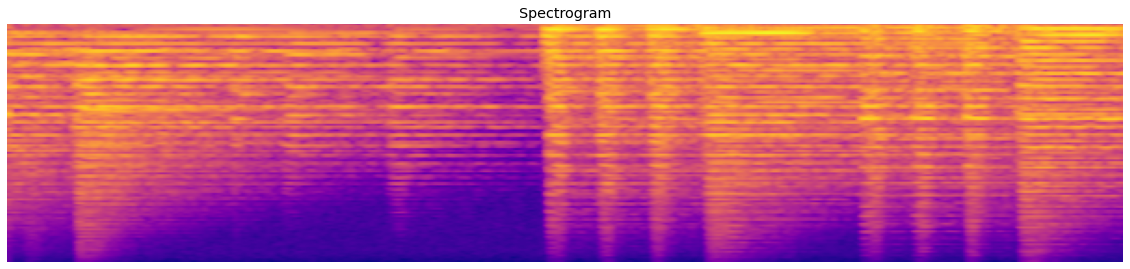

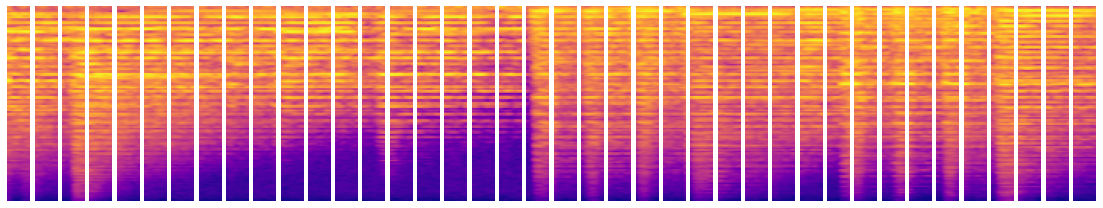

In [3]:
path = './train/classical/1688451846481878412.wav'
# 1688451846481878412.wav
# 1161154212832220511.wav
# 1429195257218202828.wav
n_frames_per_example = 15
axis = False

ipd.display(ipd.Audio(path))

features = extract_features(path, n_frames_per_example=n_frames_per_example)

features = [
    feature.reshape(-1, n_frames_per_example)
    for feature in features
]

plt.figure(figsize=(20,5))
plt.title('Spectrogram')
plt.imshow(np.hstack(features), cmap='plasma')
if axis:
    plt.xlabel('seconds')
    plt.ylabel('mel')
else:
    plt.axis('off')
plt.savefig('spectrogram.png', dpi=200)
plt.show()

plt.figure(figsize=(20,5))
for i, feature in enumerate(features):
    plt.subplot(1, len(features) + 1, i + 1)
    plt.imshow(feature, cmap='plasma')
    plt.axis('off')
plt.show()

# Prepare Train Dataset

In [4]:
def load_folder_data(
        path: Path, 
        train: bool, 
        params: Dict[str, int]
    ) -> Tuple[
        List[List[np.ndarray]],
        List[str],
        List[str]
    ]:
    
    features: List[List[np.ndarray]] = []
    labels: List[str] = []
    file_names: List[str] = list(path.rglob('*.wav'))

    for file_path in file_names:
        
        file_features = extract_features(file_path, **params)

        features.append(file_features)
        
        if train:
            class_name = file_path.parent.name
            labels.append([class_name] * len(file_features))
    
    return features, labels, file_names

In [5]:
params = {
    'sample_rate': 22050,
    'hop_length': 220,
    'n_fft': 2048,
    'n_frames_per_example': 1
}
train_path = Path('./train')
test_path = Path('./test')
SEED = 42
test_size = 0.1

In [6]:
class_names = [folder.name for folder in train_path.iterdir()]

class_name2id = {
    class_name: class_id
    for class_id, class_name in enumerate(class_names)
}

features, labels, file_names = load_folder_data(train_path, train=True, params=params)

labels = [
    [class_name2id[label] for label in label_list]
    for label_list in labels
]

In [7]:
features_train, features_test, labels_train, labels_test, files_train, files_test = \
train_test_split(
    features, labels, file_names, test_size=test_size, random_state=SEED
)

In [8]:
X_train = np.vstack([x for list_ in features_train for x in list_])
y_train = np.array([x for list_ in labels_train for x in list_])

In [9]:
X_train.shape

(2438084, 128)

In [ ]:
%%time

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SGDClassifier(loss='log',verbose=999))
]).fit(X_train, y_train)

In [28]:
%%time
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=20,
                                max_depth=None,
                                max_features='sqrt',
                                verbose=999,
                                n_jobs=10)
rf_clf.fit(X_train, y_train)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
building tree 1 of 20building tree 2 of 20building tree 3 of 20


building tree 4 of 20
building tree 5 of 20building tree 6 of 20

building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:  3.2min

building tree 12 of 20[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:  3.2min remaining: 28.6min

building tree 13 of 20[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:  3.2min remaining: 18.2min

building tree 14 of 20[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:  3.2min remaining: 12.9min

building tree 15 of 20[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:  3.2min remaining:  9.7min

building tree 16 of 20[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:  3.2min remaining:  7.6min

building tree 17 of 20[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:  3.3min remainin

RandomForestClassifier(max_features='sqrt', n_estimators=20, n_jobs=10,
                       verbose=999)

In [29]:
model_accuracy(rf_clf)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

0.8822222222222222

In [ ]:
%%time
from sklearn.linear_model import RidgeClassifier

ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RidgeClassifier())
]).fit(X_train, y_train)

In [ ]:
model_accuracy(pipe)

In [26]:
def model_accuracy(model):
    X_test = np.vstack([
        feature for feature_list in features_test 
        for feature in feature_list
    ])
    
    y_pred = np.array([
        pipe.predict_proba(np.vstack(feature_list)).mean(0).argmax()
        for feature_list in features_test
    ])
    
    y_test = np.array([label_list[0] for label_list in labels_test])
    return (y_test == y_pred).mean()

In [30]:
pipe = rf_clf

# Interpretation

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | e

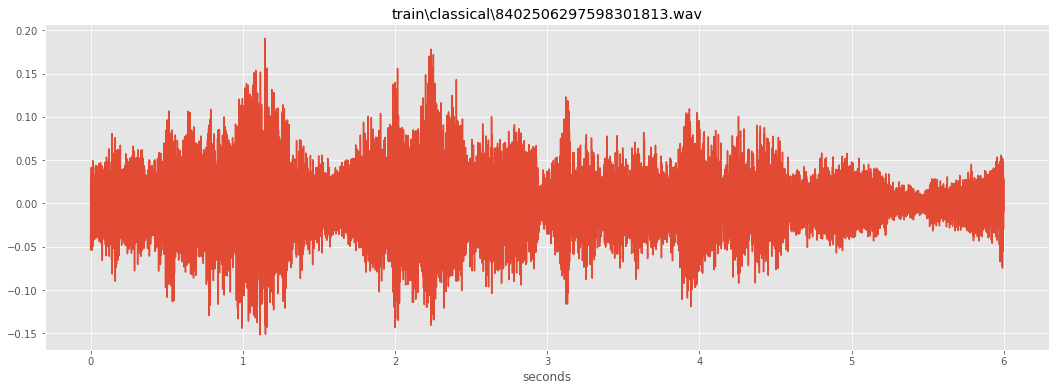

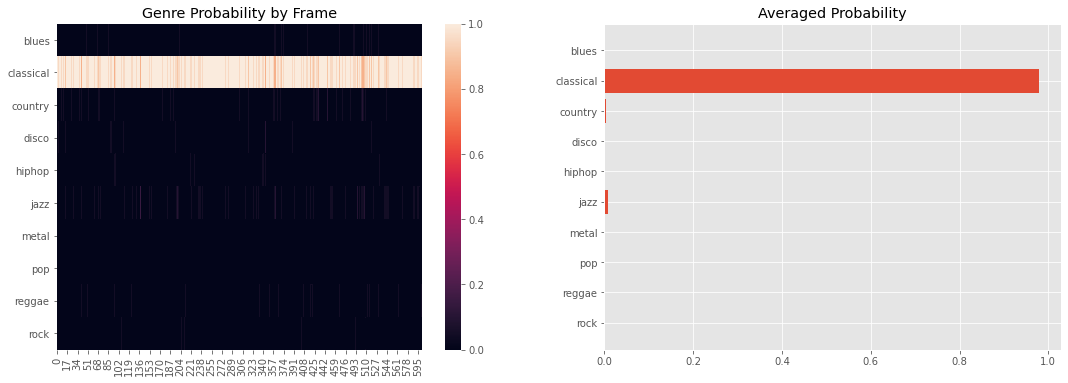

In [32]:
test_id = 0

predictions = pipe.predict_proba(np.vstack(features_train[test_id]))

plt.figure(figsize=(18,6))
plt.title(files_train[test_id])
wave_form = load_wav(files_train[test_id], sample_rate=params['sample_rate'])
time_axis = [x / params['sample_rate'] for x in range(wave_form.size)]
plt.plot(time_axis, wave_form)
plt.xlabel('seconds')
plt.show()

ipd.display(ipd.Audio(files_train[test_id]))
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.title('Genre Probability by Frame')
sns.heatmap(
    predictions.T,
    yticklabels=class_names
)

plt.subplot(122)
plt.title('Averaged Probability')
plt.barh(class_names, predictions.mean(0))
plt.gca().invert_yaxis()
plt.show()

## Confusion matrix

In [33]:
def plot_conf_matrix(y_test: np.ndarray, y_pred: np.ndarray, class_names: List[str], annot: bool=False) -> None:
    
    plt.figure(figsize=(8,6))
    plt.title(f"Accuracy: {(y_test == y_pred).mean():.2f}")
    sns.heatmap(
        confusion_matrix(y_test, y_pred), 
        xticklabels=class_names, 
        yticklabels=class_names,
        linewidths=.5,
        annot=annot
    )
    plt.show()

### by frame

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.6s remaining:    6.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.6s remaining:    3.8s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.6s remaining:    2.7s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.6s remaining:    2.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.6s remaining:    1.6s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.6s remaining:    1.2s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.6s remaining:    1.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.6s remaining:    0.8s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    1.1s remaining:    0.8s
[Parallel(n_jobs=10)]: Done  12 out of  20 | e

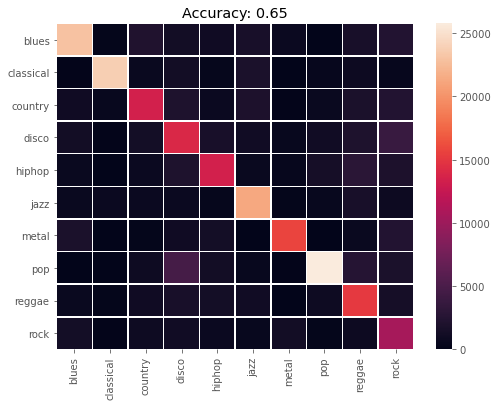

In [34]:
X_test = np.vstack([
    feature for feature_list in features_test 
    for feature in feature_list
])

y_test = np.array([label for label_list in labels_test for label in label_list])

y_pred = pipe.predict(X_test)

plot_conf_matrix(y_pred, y_test, class_names)

### by record

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | e

[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:   

[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks

[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | el

[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | el

[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend T

[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend T

[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:   

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | e

[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:   

[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:   

[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | el

[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:   

[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:   

[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | el

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | e

[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | e

[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | el

[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks

[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:   

[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks

[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks

[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:   

[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | el

[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:   

[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:   

[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend T

[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | el

[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | el

[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:   

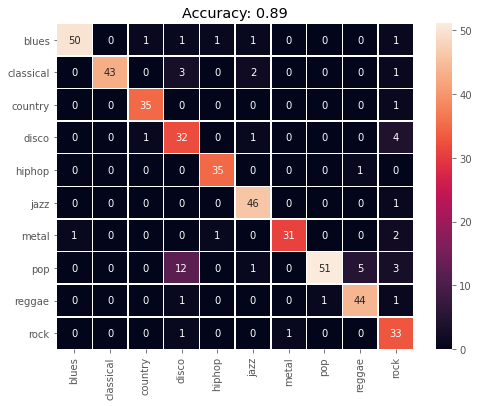

In [35]:
y_pred = np.array([
    pipe.predict_proba(np.vstack(feature_list)).mean(0).argmax()
    for feature_list in features_test
])

y_test = np.array([label_list[0] for label_list in labels_test])

plot_conf_matrix(y_pred, y_test, class_names, annot=True)

# Test

In [36]:
test_features, _, test_pathes = load_folder_data(test_path, train=False, params=params)

In [37]:
predictions = [
    class_names[
        pipe.predict_proba(
            np.vstack(test_feature)
        ).mean(0).argmax()
    ]
    for test_feature in test_features
]

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | e

[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:   

[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | el

[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | el

[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | el

[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    1.1s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.7s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.5s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | el

[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:   

[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | el

[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | el

[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:   

[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend T

[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | e

[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | el

[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | e

[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | el

[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | el

[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | el

[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend T

[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | el

[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:   

[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | el

[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | el

[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks

[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:   

[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | el

[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend T

[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | e

[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:   

[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:   

[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | e

[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:   

[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:   

[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks

[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:   

[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks

[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | el

[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks

[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:   

[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:   

[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 

In [38]:
(
    pd.DataFrame({
        'index': [test_wav_path.name for test_wav_path in test_path.iterdir()],
        'genre': predictions
    })
    .to_csv('submit.csv', index=False)
)